Thomas Dougherty

Probability and Statistics for Computer Science


### Analysis of the On-Time Performance (OTP) of New Jersey Transit Commuter Rail<br>
On-time performance refers to the level of success of a service adhering to its schedule. In this example I'll be exploring NJT commuter rail from March 2018 to March 2020. On-time performance data can be used for schedule planning, passenger information systems, and comparison to weather data. 
    

#### Data cleanup

In [1]:

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import statistics
import scipy.stats as stats
from IPython.core import display
from helper_functions import *

#all_services = helper.combine_csvs(r"data/services/")
print("Reading CSV....")
all_services = pd.read_csv(r"data/all_services.csv")
all_services = helper.format_services(all_services)
all_services

Reading CSV....
Dropping columns...
Changing datatypes...
Done formatting dataframe


,date,train_id,from,to,scheduled_time,actual_time,delay_minutes,line
0,2018-08-01,4631,Philadelphia,Philadelphia,2018-08-01 15:19:00,2018-08-01 15:19:14,0.233276,Atl. City Line
1,2018-08-01,4631,Philadelphia,Pennsauken,2018-08-01 15:40:00,2018-08-01 15:40:18,0.300049,Atl. City Line
2,2018-08-01,4631,Pennsauken,Cherry Hill,2018-08-01 15:47:00,2018-08-01 15:48:22,1.366211,Atl. City Line
3,2018-08-01,4631,Cherry Hill,Lindenwold,2018-08-01 15:58:00,2018-08-01 16:03:15,5.250000,Atl. City Line
4,2018-08-01,4631,Lindenwold,Atco,2018-08-01 16:05:00,2018-08-01 16:10:24,5.398438,Atl. City Line
...,...,...,...,...,...,...,...,...
5761579,2019-03-31,6924,Orange,Brick Church,2019-03-31 14:07:00,2019-03-31 14:14:20,7.332031,Morristown Line
5761580,2019-03-31,6924,Brick Church,East Orange,2019-03-31 14:10:00,2019-03-31 14:17:09,7.148438,Morristown Line
5761581,2019-03-31,6924,East Orange,Newark Broad Street,2019-03-31 14:16:00,2019-03-31 14:23:10,7.167969,Morristown Line
5761582,2019-03-31,6924,Newark Broad Street,Secaucus Upper Lvl,2019-03-31 14:25:00,2019-03-31 14:32:01,7.015625,Morristown Line


## Visualization of On Time Performance

#### All Services by Season

Using the date column, arrivals will be divided into four primary categories. The arrivals will be sub-categorized by how many minutes late then plotted onto a pie chart to show on time performance in the seasons of the year. <br>
Pie charts will be used to show the breakdown of how late trains are relative to all trains in the given time periods.

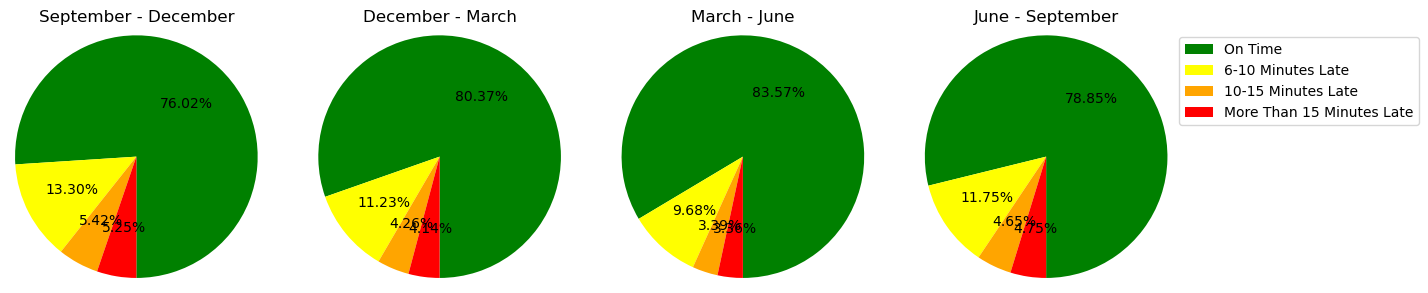

In [2]:
late_labels = ['On Time', '6-10 Minutes Late', '10-15 Minutes Late', 'More Than 15 Minutes Late']
late_colors = ['green', 'yellow', 'orange', 'red']


data_fall = helper.categorize_lateness(all_services[(all_services['date'].dt.month >= 9) & (all_services['date'].dt.month <= 12)])
# could not get a 'true' boolean value for the winter months and had to broken up into two separate dfs
df1 = all_services[(all_services['date'].dt.month <= 3)]
df2 = all_services[(all_services['date'].dt.month >= 12)]
result = pd.concat([df1,df2])
data_winter = helper.categorize_lateness(result) 
data_spring = helper.categorize_lateness(all_services[(all_services['date'].dt.month >= 3) & (all_services['date'].dt.month <=6)])
data_summer = helper.categorize_lateness(all_services[(all_services['date'].dt.month >= 6) & (all_services['date'].dt.month <=9)])


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)

ax1.pie(data_fall, colors=late_colors, radius = 1.2, autopct = "%0.2f%%", startangle=270)
ax1.title.set_text('September - December')
ax2.pie(data_winter, colors=late_colors, radius = 1.2, autopct = "%0.2f%%", startangle=270)
ax2.title.set_text('December - March')
ax3.pie(data_spring, colors=late_colors, radius = 1.2, autopct = "%0.2f%%", startangle=270)
ax3.title.set_text('March - June')
ax4.pie(data_summer, colors=late_colors, radius = 1.2, autopct = "%0.2f%%", startangle=270)
ax4.title.set_text('June - September')

fig.set_figwidth(15)
fig.set_figheight(5)

plt.legend(bbox_to_anchor = (1.0, 1.0), labels = late_labels)
plt.show()

In Autumn, tree leaves tend to fall on the rails. As they're crushed by the weight of the trains, the wheels of the train and the rails they ride on become coated in a low-friction residue. The buildup is incremental with each passing train. So unlike snow, the buildup cannot be prevented by the regular running of trains. These condition makes it difficult for trains to accelerate, decelerate, and maintain safe speeds leading to delays and other service disruptions so we can expect a lower On Time Performance during the autumn months. 

### Reporting to Final Destination On Time: New York Penn Station vs Hoboken Terminal<br>
New York Penn and Hoboken Terminal are two major termini for New Jersey Transit. However, New York Penn is the busiest transportation facility in the western hemisphere serving both commuter and intercity trains whereas Hoboken terminal serves exclusively commuter rail. The North River Tunnels that connect to NYP are aging pieces of infrastructure as well. Built over a century ago, the tunnels under the Hudson River have been experienced flooding, electrical problems, and other issues. The tunnels are operating at capacity and frequently result in congestion and delays.<br>

For easy comparison, bar charts will be used to visualize the OTP of both stations at different peak times.

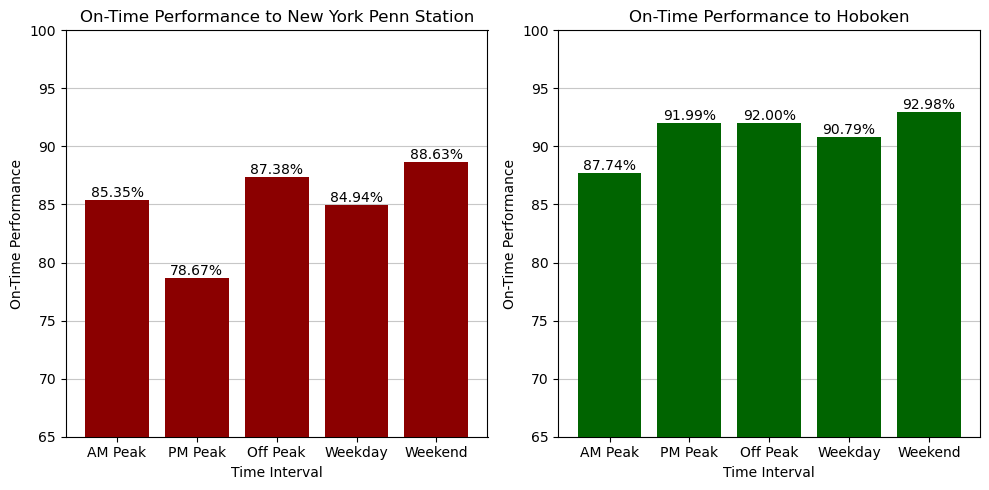

In [3]:
categories = ['AM Peak', 'PM Peak', 'Off Peak', 'Weekday', 'Weekend']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# Plot for New York Penn Station
otps = helper.otp_for_destination(all_services,'New York Penn Station')
ax = axs[0]
ax.grid(axis='y', linestyle='solid', alpha=0.7, zorder=0)
xpos = [1, 2, 3, 4, 5]
bars = ax.bar(xpos, otps, color='darkred',zorder=3)

ax.set_title('On-Time Performance to New York Penn Station')
ax.set_xlabel('Time Interval')
ax.set_ylabel('On-Time Performance')
ax.set_ylim(65,100)
ax.set_xticks(xpos)
ax.set_xticklabels(categories)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f"{otps[i]:.2f}%", ha='center', va='bottom', color='black')

# Plot for Hoboken
otps = helper.otp_for_destination(all_services,'Hoboken')
ax = axs[1]
ax.grid(axis='y', linestyle='solid', alpha=0.7, zorder=0)
xpos = [1, 2, 3, 4, 5]
bars = ax.bar(xpos, otps, color='darkgreen',zorder=3)

ax.set_title('On-Time Performance to Hoboken')
ax.set_xlabel('Time Interval')
ax.set_ylabel('On-Time Performance')
ax.set_ylim(65,100)
ax.set_xticks(xpos)
ax.set_xticklabels(categories)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f"{otps[i]:.2f}%", ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

## Standard Deviation <br>
An error bar chart will be plotted to show the standard deviation over time. This can be useful for identifying trends and sources of error. If standard deviation is going up over time, then service is more consistent and reliable. If it is going down, service is getting less consistent. <br>

At any given point, low standard deviation indicates that a rail service is consistent in achieving its scheduled arrival times. A higher standard deviation of on-time performance can be interpreted as less reilable or consistent service. It can also indicate inefficient routing of trains or an un-optimized train schedule. <br>


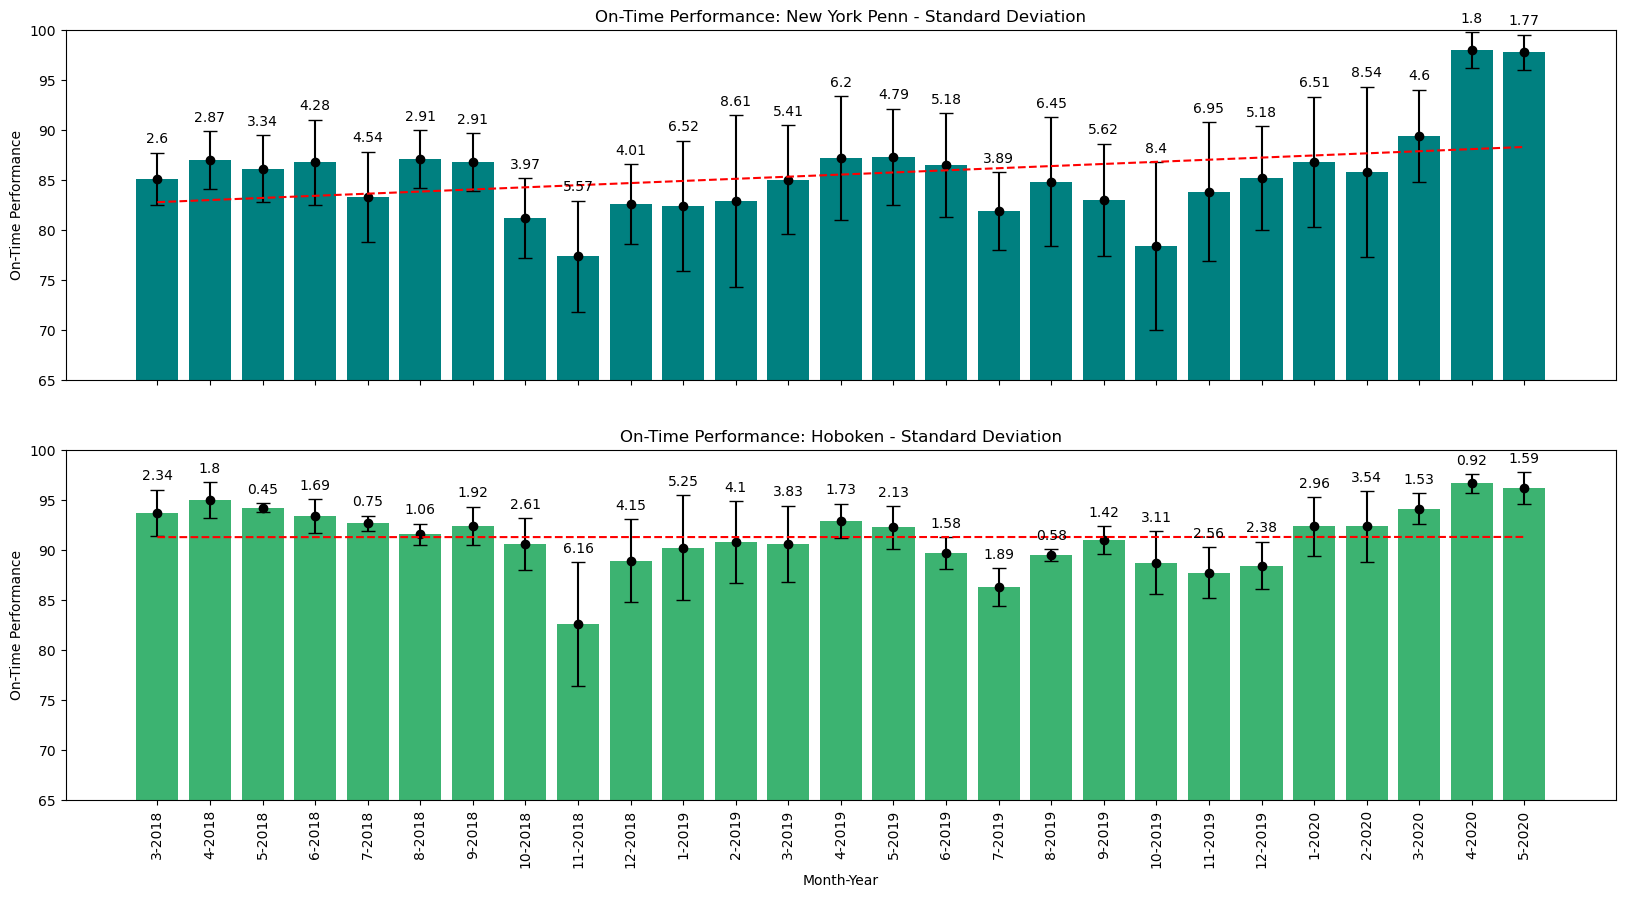

In [4]:

all_services['date'] = pd.to_datetime(all_services['date'])
all_services['year'] = all_services['date'].dt.year
all_services['month'] = all_services['date'].dt.month

## TO DO: look into data accuracy. This seems to be averaging together the OTPs of the peak intervals
otps_by_month_year_ny = all_services.groupby(['year', 'month']).apply(lambda x: np.mean(helper.otp_for_destination(x, 'New York Penn Station')))
std_devs_by_month_year_ny = all_services.groupby(['year', 'month']).apply(lambda x: helper.calculate_std_dev(helper.otp_for_destination(x, 'New York Penn Station')))
otps_by_month_year_hoboken = all_services.groupby(['year', 'month']).apply(lambda x: np.mean(helper.otp_for_destination(x, 'Hoboken')))
std_devs_by_month_year_hoboken = all_services.groupby(['year', 'month']).apply(lambda x: helper.calculate_std_dev(helper.otp_for_destination(x, 'Hoboken')))

x_labels = [f"{month}-{year}" for year, month in otps_by_month_year_ny.index]
xpos = np.arange(len(otps_by_month_year_ny))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

# Plot New York Penn data
ax1.bar(xpos, otps_by_month_year_ny, color='teal', zorder=0)
ax1.errorbar(xpos, otps_by_month_year_ny, yerr=std_devs_by_month_year_ny, fmt='o', color='black', zorder=0, capsize=5)
for i, (mean, std_dev) in enumerate(zip(otps_by_month_year_ny, std_devs_by_month_year_ny)):
    ax1.text(i, mean + std_dev + 1, round(std_dev, 2), horizontalalignment='center')
slope, intercept = np.polyfit(xpos, otps_by_month_year_ny, 1)
ax1.plot(xpos, slope*xpos + intercept, color='red', linestyle='--')
ax1.set_ylabel('On-Time Performance')
ax1.set_ylim([65, 100])
ax1.set_title('On-Time Performance: New York Penn - Standard Deviation')

# Plot Hoboken data
ax2.bar(xpos, otps_by_month_year_hoboken, color='mediumseagreen', zorder=0)
ax2.errorbar(xpos, otps_by_month_year_hoboken, yerr=std_devs_by_month_year_hoboken, fmt='o', color='black', zorder=0,capsize=5)
for i, (mean, std_dev) in enumerate(zip(otps_by_month_year_hoboken, std_devs_by_month_year_hoboken)):
    ax2.text(i, mean + std_dev + 1, round(std_dev, 2), horizontalalignment='center')
slope, intercept = np.polyfit(xpos, otps_by_month_year_hoboken, 1)
ax2.plot(xpos, slope*xpos + intercept, color='red', linestyle='--')
ax2.set_xlabel('Month-Year')
ax2.set_ylabel('On-Time Performance')
ax2.set_ylim([65, 100])
ax2.set_title('On-Time Performance: Hoboken - Standard Deviation')

plt.xticks(xpos, x_labels, rotation=90)
plt.show()


## Possible Distributions for 'Minutes Late'<br>
Now we'll identify possible distributions for how late trains are when they are "officially late". The delay minutes values are continuous so we will have to use the appropriate functions.

/home/thomas/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/thomas/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


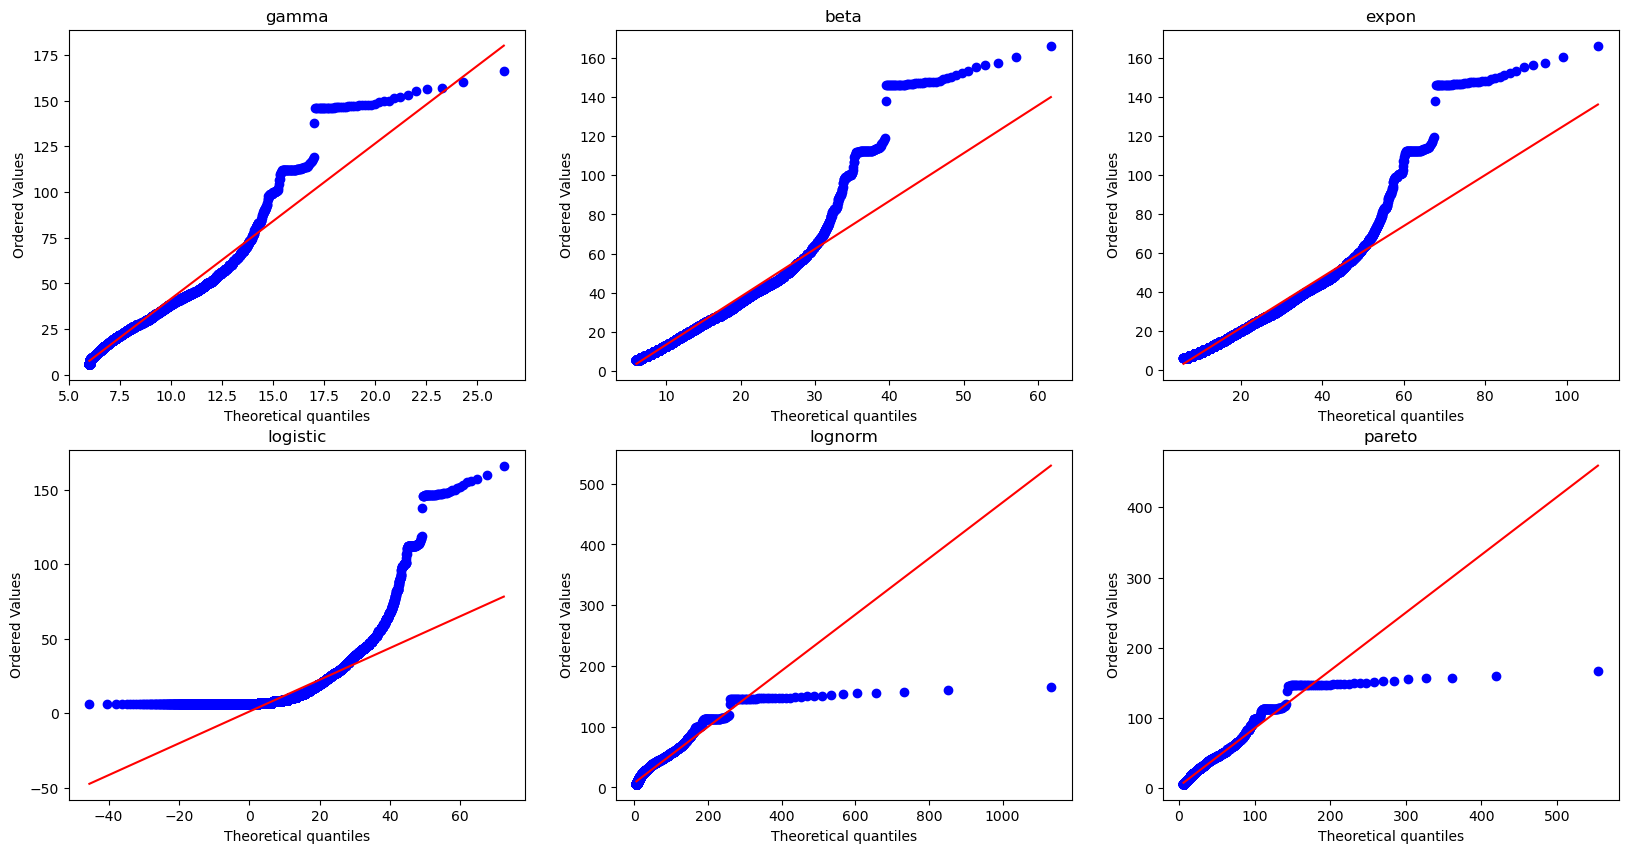

In [17]:
trains_to_nyp = all_services[(all_services['to'] == 'New York Penn Station')].copy()

data = helper.get_late_arrivals(trains_to_nyp)

distributions = [stats.gamma, stats.beta, stats.expon, stats.logistic, stats.lognorm, stats.pareto]

# Create subplots
fig, axs = plt.subplots(2, len(distributions)//2, figsize=(20,10))

for row in range(2):
    for col, dist in enumerate(distributions[row*len(distributions)//2:(row+1)*len(distributions)//2]):
        # Fit the distribution to the data
        params = dist.fit(data)
        # Create a probability plot
        res = stats.probplot(data, sparams=params, dist=dist, plot=axs[row, col])
        # Set the title of the subplot
        axs[row, col].set_title(dist.name)

# Show the plot
plt.show()

## Skewness (come back to this) <br>
Skewness is a statistical measure that describes the asymmetry of a probability distribution. It measures the extent of which data points are skewed to the left or right of the normal distribution. However, it is just one shape of a probability distribution and may not paint the whole picture of a dataset.

This dataset does not measure early arrivals (the 'delay_minutes' column doesn't contain any negative values). So a positively skewed distribution would indicate that there are more delays that are longer in duration compared to delays that are shorter in duration. This could indicate that there are issues with reliability of the service. If the data becomes more skewed to the right over time it could indicate conditions are worsening over time be it equipment failure, infrastructure problems, or staffing shortages. If it is becoming more skewed to the left, or closer to 0, it could indicate improvements are being made.

In [6]:
trains_to_nyp = all_services[(all_services['to'] == 'New York Penn Station')].copy()
delay_minutes = trains_to_nyp['delay_minutes']
# Remove invalid values
delay_minutes = delay_minutes[~np.isnan(delay_minutes)]

max_abs_value = np.max(np.abs(delay_minutes))
normalized_delay_minutes = delay_minutes / max_abs_value
normalized_delay_minutes = np.nan_to_num(normalized_delay_minutes, nan=0.0, posinf=0.0, neginf=0.0)

mean = np.mean(normalized_delay_minutes)
mean *= max_abs_value

median = np.median(trains_to_nyp['delay_minutes'])

std_dev = statistics.stdev(delay_minutes)

skewness = (3 * (mean - median)) / std_dev

print("Skewness:", skewness)
trains_to_nyp['date'] = pd.to_datetime(trains_to_nyp['date'])
trains_to_nyp.loc['year'] = trains_to_nyp['date'].dt.year
trains_to_nyp.loc['month'] = trains_to_nyp['date'].dt.month
print(helper.categorize_lateness(trains_to_nyp))



otps = helper.get_monthly_otps(trains_to_nyp)
mask = np.array([x is None for x in otps])
otps[mask] = np.nan
print(otps)

Skewness: 1.1208694256238207
[172765, 11606, 6911, 10650]


TypeError: only integer scalar arrays can be converted to a scalar index